# **Sequence-to-Sequence Learning with Tranformers**

Last week, we have seen a tutorial on RNN-based sequence-to-sequence learning.
This week we will solve the same sequence replay task with another popular sequence-to-sequence learning model: [Transformers](https://arxiv.org/abs/1706.03762).

Transformers are attention-based models that can process sequences without the need for RNNs. RNNs are inherently sequential models, while transformers parallelize the computations much more (making them more suitable for current GPUs).

Transformers are everywhere. They are used in speech processing, machine translation, computer vision, and natural language processing. The famous [ChatGPT](https://chat.openai.com/) relies on this architecture.

In the first part of this tutorial, we will refresh RNN-based sequence-to-sequence learning,  and we will gradually move towards transformers step by step.

In [ ]:
import torch
import copy
torch.manual_seed(1)

## **1. The Sequence Replay Task**
As last week, we will use the sequence replay task. Basically, we read the inputs with a model (called "encoder"). We then ask another model (called "decoder") to replay the inputs (in the same order). We will use binary inputs only (i.e., our input sequence is composed of 0s or 1s only).

We can create artificial data for this task with the following function:

In [ ]:
def data_generation(L, N, D=1, prob=0.05):
  """This function generates random sequences of 0 and 1.

  Arguments
  ---------
  L : int
    Lenght of the sequences.
  N: int
    Number of examples.
  D: int
    Number of output features.
  prob: float:
    Probability to draw a 1.

  Returns
  ---------
  X: torch.Tensor
    Tensor of dimensionality (L,N,D) containing
    the generated sequences.
  """
  X = torch.bernoulli(torch.full((N, L, D), prob)).float()
  return X

We generate 1000 sequences of 16 elements for training and 500 for test:

In [ ]:
L = 16 # sequence length
N = 1000 # number of examples
D = 1 # output features

X_train = data_generation(L, N, D=1, prob=0.5)
X_test = data_generation(L, 500, D=1, prob=0.5)

print(X_train.shape)
print(X_test.shape)

torch.Size([1000, 16, 1])
torch.Size([500, 16, 1])


We have to set `prob=0.5` to approximatively have the same number of zeros and ones in the sequences.

# **2. Sequence-to-Sequence Learning with RNNs**

Different architectures can be applied here.
We start with a basic one that uses vanilla RNNs for encoding and decoding without any attention mechanisms.

##**2.2 RNN with Attention**

Attention mechanisms are a way to add dynamic connections to your architecture.
These connections are not "hard-coded" but are learned and depend on the input and status of the model.

This is an encoder-decoder system with Bahdanau's attention thath we implemented last week:

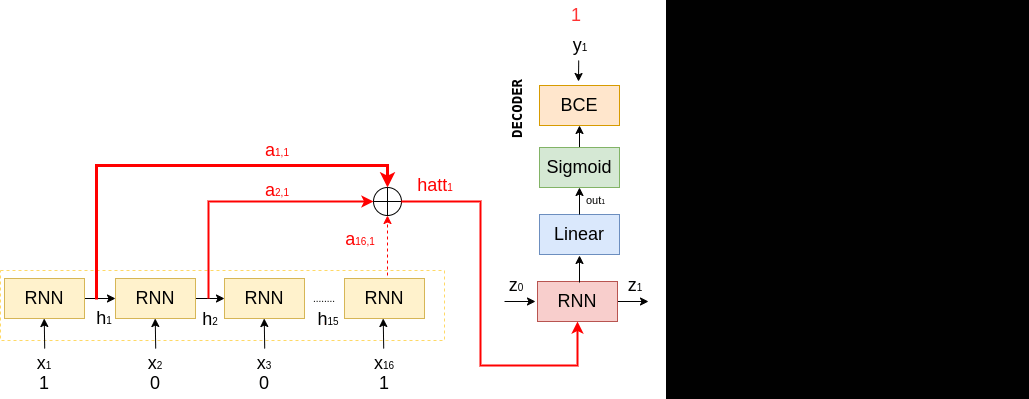

Let's implement this model:

In [ ]:
def training_loop(X, y, model, loss, optimizer, num_epoch=500, batch_size=100, epoch_check=50):

  # Getting the number of input samples
  N = X.shape[0]

  # Initializing best loss
  best_loss = float('inf')
  best_model = copy.deepcopy(model)

  # Training Loop
  for epoch in range(num_epoch):
    for i in range(0, N, batch_size):

      # Minibatch selection (on X and y)
      # Your code here. Aim for 2 lines
      Xi = X[i:i+batch_size, :, :]
      yi = y[i:i+batch_size, :, :]

      # Run Model
      logits, _ = model(Xi)

      # Compute the losse
      l = loss(logits, yi)

      # Update the parameters
      model.zero_grad()
      l.backward()

      # Gradient clipping help improving training stability
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
      optimizer.step()

    # Print the training loss
    if (epoch + 1) % epoch_check == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))

        # Saving best model
        if l.item() <= best_loss:
          best_loss = l.item()
          best_model = copy.deepcopy(model)

  return best_model

In [ ]:
class AttentionMLP(torch.nn.Module):
    def __init__(self, hidden_size_enc, hidden_size_dec, hidden_size):
        super(AttentionMLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(hidden_size_enc+hidden_size_dec, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1, bias=False)
        )

    def forward(self, h, zt):
        zt = torch.cat([zt]*h.shape[1], dim=1)
        x = torch.cat([zt, h],dim=2)
        x = self.layers(x)
        att_w = torch.nn.functional.softmax(x, dim=1)
        return att_w

class EncoderDecoderRNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=8, num_layers=1):
    super(EncoderDecoderRNN, self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers

    # Encoder initialization
    self.encoder = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    # Decoder initialization
    self.decoder = torch.nn.RNN(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    # Linear initialization
    self.linear = torch.nn.Linear(in_features=hidden_size, out_features=1)

    # Attention MLP
    self.attMLP = AttentionMLP(hidden_size, hidden_size, hidden_size)


  def forward(self, X):

    # Run the RNN encoder
    H, _ = self.encoder(X)

    # Run the decoding steps
    zt = torch.zeros(self.num_layers, X.shape[0], self.hidden_size, device=X.device)
    Z = []
    att_weights = []

    for i in range(X.shape[1]):

      # Compute the attention weights
      att_w = self.attMLP(H,zt[-1].unsqueeze(1))

      # Compute the weighted average of the encoding states
      h_att = torch.matmul(att_w.transpose(1,-1), H)

      # Getting the new decoding state
      z, zt = self.decoder(h_att,zt)

      # Storing the states and attention
      Z.append(z)
      att_weights.append(att_w)

    Z = torch.cat(Z, dim=1)
    att_weights = torch.cat(att_weights, dim=2)

    # Run the linear transformation
    out = self.linear(Z)

    if not(self.training):
      # Apply the sigmoid and a threshold on it.
      out = (torch.sigmoid(out) > 0.5).int()

    return out, att_weights

Let's train our model:

In [ ]:
# Hyperparameters
num_epoch = 650
batch_size = 50
lr = 0.004
hidden_size = 15
num_layers= 1

# Initialization
model = EncoderDecoderRNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Run the training loop
best_model = training_loop(X_train, X_train, model, loss, optimizer, num_epoch, batch_size)

Epoch 050: Train_loss: 0.2322 
Epoch 100: Train_loss: 0.1186 
Epoch 150: Train_loss: 0.0340 
Epoch 200: Train_loss: 0.0009 
Epoch 250: Train_loss: 0.0440 
Epoch 300: Train_loss: 0.0045 
Epoch 350: Train_loss: 0.0006 
Epoch 400: Train_loss: 0.0040 
Epoch 450: Train_loss: 0.0107 
Epoch 500: Train_loss: 0.0288 
Epoch 550: Train_loss: 0.1944 
Epoch 600: Train_loss: 0.0843 
Epoch 650: Train_loss: 0.0004 


In some cases, training might be a bit "turbolent", but  you should see a low training loss (which is zero or close to zero) for the best model. If this is not the case, re-run the code cell above (it will reinitialize the network and start training again).


Let's evaluate it and show the attention weights:

Test Error: 0.000000
tensor([[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]], dtype=torch.int32)
tensor([[1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.]])


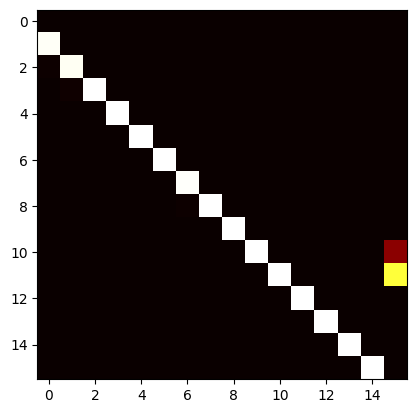

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Put the model in eval mode
best_model.eval()

# Run the model
out, att_weights = best_model(X_test)

# Compute Test Error
err = (out!=X_test).sum()/X_test.numel()

# Print Test Error
print("Test Error: %f" %(err*100))
print(out[0,:].transpose(0,1))
print(X_test[0,:].transpose(0,1))

# Plot Attention
plt.imshow(att_weights[0].detach().cpu().numpy(),cmap='hot', interpolation='nearest')
plt.show()

You should see a diagonal trend in the attention matrix. Note the RNNs have some memory ability. This means, for instance, that the encoding state $h_{10}$ can keep the information of input $x_1,..x_{10}$.

In some cases, the solution that the network discovers is to not look at $h_{10}$ when decoding the 10th element, but look at any previous one (typically the closest ones). In other words, the diagonal that emerges from the attention might be a bit shifted. Try to run training multiple times on different data to see the different solutions.

##**3. RNN-free Architectures**

One issue with RNN-based sequence-to-sequence processing is that the training pipeline is sequential. We indeed cannot process all the encoding and decoding time steps in parallel, but we need to process them one after the other due to the recurrent nature of RNNs.

This way, we do not exploit too much of the huge parallelization offered by modern GPUs.

*Do you think we can remove RNNs from the sequence-to-sequence pipeline?*

###**3.1 Removing RNNs from the Encoder**
Let's go step by step and try to replace the encoding RNN with a simple MLP:


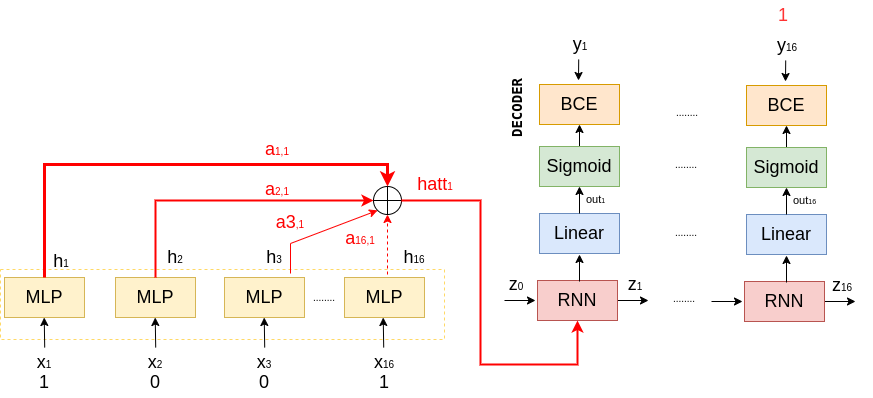

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

We can use the MLP above in the encoder-decoder architecture:

In [ ]:
class EncoderMLPDecoderRNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=8, num_layers=1):
    super(EncoderMLPDecoderRNN, self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers

    # Encoder initialization
    self.encoder = MLP(input_size=input_size, hidden_size=hidden_size)

    # Decoder initialization
    self.decoder = torch.nn.RNN(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    # Linear initialization
    self.linear = torch.nn.Linear(in_features=hidden_size, out_features=1)

    # Attention MLP
    self.attMLP = AttentionMLP(hidden_size, hidden_size, hidden_size)


  def forward(self, X):
    """This function encodes the input sequences with an RNN. A decoder is fed with
    the last encoded state and generates an output sequence with the same length
    of the input one.

    Arguments
    ---------
    X : torch.Tensor
      Tensor containing the sequences (N, L, 1).

    Returns
    ---------
    out: torch.Tensor
      Tensor (N,L,1) containing the logits for each decoded output.
    """
    # Run the RNN encoder
    H = self.encoder(X)

    # Run the decoding steps
    zt = torch.zeros(self.num_layers, X.shape[0], self.hidden_size, device=X.device)
    Z = []
    att_weights = []

    for i in range(X.shape[1]):

      # Compute the attention weights
      att_w = self.attMLP(H,zt[-1].unsqueeze(1))
      h_att = torch.matmul(att_w.transpose(1,-1), H)
      z, zt = self.decoder(h_att,zt)

      Z.append(z)
      att_weights.append(att_w)

    Z = torch.cat(Z, dim=1)
    att_weights = torch.cat(att_weights, dim=2)


    # Run the linear transformation
    out = self.linear(Z)

    if not(self.training):
      # Apply the sigmoid and a threshold on it.
      out = (torch.sigmoid(out) > 0.5).int()

    return out, att_weights

In [ ]:
# Hyperparameters
num_epoch = 200
batch_size = 50
lr = 0.004
hidden_size = 15
num_layers= 1

# Initialization
model = EncoderMLPDecoderRNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Run the training loop
best_model = training_loop(X_train, X_train, model, loss, optimizer, num_epoch, batch_size)

Epoch 050: Train_loss: 0.6570 
Epoch 100: Train_loss: 0.6586 
Epoch 150: Train_loss: 0.6589 
Epoch 200: Train_loss: 0.6601 


Unfortunately, it looks like the network is not converging.

*Could you understand why?*

Without the RNN, each input is independent of the others. We thus do not have the position information that tells at which input each encoding state corresponds anymore. The notion of position is crucial for the decoder as the information about the order of the input tokens helps it significantly.

*What can we do?*

We can inform the network about the position of each input with **positional embeddings**.

There are different ways to inject positional embeddings into a neural network. In this case, we just use a simple counter (normalized by the maximum sequence length).


In [ ]:
class EncoderMLPDecoderRNN(torch.nn.Module):
  def __init__(self, rnn_type=torch.nn.RNN, input_size=1, hidden_size=8, num_layers=1):
    super(EncoderMLPDecoderRNN, self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers

    # Encoder initialization
    self.encoder = MLP(input_size=input_size+1, hidden_size=hidden_size)

    # Decoder initialization
    self.decoder = rnn_type(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    # Linear initialization
    self.linear = torch.nn.Linear(in_features=hidden_size, out_features=1)

    # Attention MLP
    self.attMLP = AttentionMLP(hidden_size, hidden_size, hidden_size)


  def forward(self, X):
    """This function encodes the input sequences with an RNN. A decoder is fed with
    the last encoded state and generates an output sequence with the same length
    of the input one.

    Arguments
    ---------
    X : torch.Tensor
      Tensor containing the sequences (N, L, 1).

    Returns
    ---------
    out: torch.Tensor
      Tensor (N,L,1) containing the logits for each decoded output.
    """

    # Positional Embeddings
    enc_posemb = torch.linspace(0, 1, X.shape[1], device=X.device).unsqueeze(0)
    enc_posemb = torch.cat([enc_posemb]*X.shape[0]).unsqueeze(2)
    X = torch.cat([X, enc_posemb], dim=2)

    # Run the RNN encoder
    H = self.encoder(X)

    # Run the decoding steps
    zt = torch.zeros(self.num_layers, X.shape[0], self.hidden_size, device=X.device)
    Z = []
    att_weights = []

    for i in range(X.shape[1]):
      # Compute the attention weights
      att_w = self.attMLP(H,zt[-1].unsqueeze(1))
      h_att = torch.matmul(att_w.transpose(1,-1), H)
      z, zt = self.decoder(h_att,zt)

      Z.append(z)
      att_weights.append(att_w)

    Z = torch.cat(Z, dim=1)
    att_weights = torch.cat(att_weights, dim=2)


    # Run the linear transformation
    out = self.linear(Z)

    if not(self.training):
      # Apply the sigmoid and a threshold on it.
      out = (torch.sigmoid(out) > 0.5).int()

    return out, att_weights

In [ ]:
# Hyperparameters
num_epoch = 650
batch_size = 50
lr = 0.004
hidden_size = 15
num_layers= 1

# Initialization
model = EncoderMLPDecoderRNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Run the training loop
best_model = training_loop(X_train, X_train, model, loss, optimizer, num_epoch, batch_size)

Epoch 050: Train_loss: 0.0869 
Epoch 100: Train_loss: 0.5821 
Epoch 150: Train_loss: 0.5216 
Epoch 200: Train_loss: 0.4503 
Epoch 250: Train_loss: 0.2429 
Epoch 300: Train_loss: 0.0393 
Epoch 350: Train_loss: 0.4016 
Epoch 400: Train_loss: 0.0001 
Epoch 450: Train_loss: 0.0000 
Epoch 500: Train_loss: 0.0000 
Epoch 550: Train_loss: 0.0000 
Epoch 600: Train_loss: 0.0000 
Epoch 650: Train_loss: 0.0000 


Now, the model converges well!

###**3.3 Removing RNNs from the Decoder**

We can now try to remove the RNN in the decoder as well.

Also for the decoder, we need to introduce positional embeddings to inform the decoder about the position of the current decoding state.

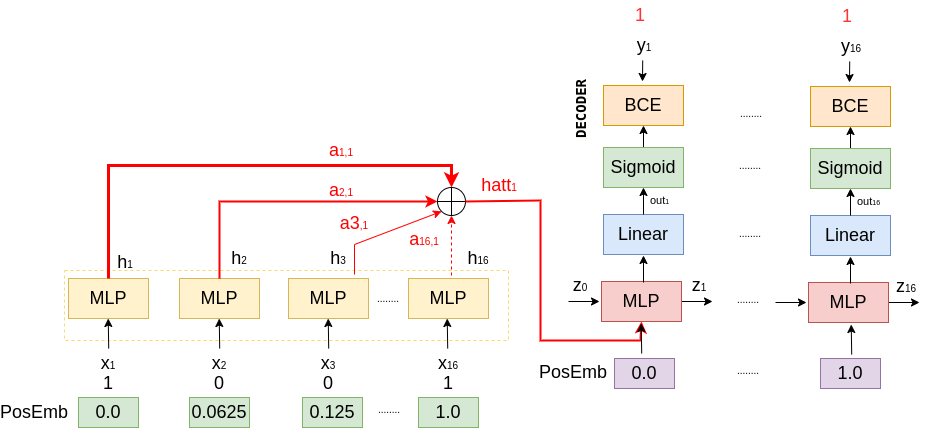

In [ ]:
class AttentionMLP(torch.nn.Module):
    def __init__(self, hidden_size_enc, hidden_size_dec, hidden_size):
        super(AttentionMLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(hidden_size_enc+hidden_size_dec, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1, bias=False)
        )

    def forward(self, h, zt):
        x = torch.cat([zt, h],dim=-1)
        x = self.layers(x)
        att_w = torch.nn.functional.softmax(x, dim=2)
        return att_w

class EncoderMLPDecoderMLP(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=8, num_layers=1):
    super(EncoderMLPDecoderMLP, self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers

    # Encoder initialization #why input size + 1 here ?
    self.encoder = MLP(input_size=input_size+1, hidden_size=hidden_size)

    # Decoder initialization
    self.linear_in = torch.nn.Linear(in_features=1, out_features=hidden_size)
    self.decoder = MLP(input_size=hidden_size, hidden_size=hidden_size)
    self.linear_out = torch.nn.Linear(in_features=hidden_size, out_features=1)


    # Attention MLP
    self.attMLP = AttentionMLP(hidden_size, hidden_size, hidden_size)



  def forward(self, X):
    """This function encodes the input sequences with an RNN. A decoder is fed with
    the last encoded state and generates an output sequence with the same length
    of the input one.

    Arguments
    ---------
    X : torch.Tensor
      Tensor containing the sequences (N, L, 1).

    Returns
    ---------
    out: torch.Tensor
      Tensor (N,L,1) containing the logits for each decoded output.
    """



    # Positional Embeddings
    # print(X.shape) #[N,L,1] -> [50,16,1]
    enc_posemb = torch.linspace(0, 1, X.shape[1], device=X.device).unsqueeze(0)
    # print(enc_posemb.shape)  # [1,N] -> [1,16]
    enc_posemb = torch.cat([enc_posemb]*X.shape[0]).unsqueeze(2)
    # print(enc_posemb.shape) #[N,L,1] -> [50,16,1]

    # The encoder has the same embeddings because the number of encodings states
    # is equal to the number of decoding states.
    dec_posemb = torch.linspace(0, 1, X.shape[1], device=X.device).unsqueeze(0) #[1,16]
    dec_posemb = torch.cat([dec_posemb]*X.shape[0]).unsqueeze(2) #[50,16,1]
    # print(dec_posemb.shape)

    # Inject positional embeddings (for encoder)
    X = torch.cat([X, enc_posemb], dim=2) #Feature Augmentation
    # print(X.shape) #[50,16,2]

    # Run the MLP encoder
    h = self.encoder(X)
    # print(h.shape) #[50,16,15] (N,L,H)
    # Inject positional embeddings (for decoder)
    #why do we need a linear layer to inject positional embedding in the decoder, while in the encoder we can do it without?
    z = self.linear_in(dec_posemb)
    # print(z.shape) #[50,16,15]

    # Stacking encoding and decoding states
    H = torch.stack([h]*z.shape[1],dim=1)
    # print(H.shape) [50,16,16,15]
    Z = torch.stack([z]*h.shape[1],dim=2)
    # print(Z.shape) #[50,16,16,15]

    # Computing attention (in parallel)
    att_w = self.attMLP(H,Z).squeeze()
    # print(att_w.shape) # [50,16,16]

    # Weighted average of encoding states
    H_att = torch.matmul(att_w, h)
    # print(H_att.shape) # [50,16,15]

    # Running the decoder
    out = self.decoder(H_att)
    # print(out.shape) #[50,16,15]

    # Run the linear transformation
    out = self.linear_out(out)
    # print(out.shape) #[50,16,1]

    if not(self.training):
      # Apply the sigmoid and a threshold on it.
      out = (torch.sigmoid(out) > 0.5).int()

    return out, att_w

In [ ]:
# Hyperparameters
num_epoch = 200
batch_size = 50
lr = 0.004
hidden_size = 15
num_layers= 1

# Initialization [50,16,1]
model = EncoderMLPDecoderMLP(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Run the training loop
best_model = training_loop(X_train, X_train, model, loss, optimizer, num_epoch, batch_size, epoch_check=10)

Epoch 010: Train_loss: 0.4122 
Epoch 020: Train_loss: 0.0000 
Epoch 030: Train_loss: 0.0000 
Epoch 040: Train_loss: 0.0000 
Epoch 050: Train_loss: 0.0000 
Epoch 060: Train_loss: 0.0000 
Epoch 070: Train_loss: 0.0000 
Epoch 080: Train_loss: 0.0000 
Epoch 090: Train_loss: 0.0000 
Epoch 100: Train_loss: 0.0000 
Epoch 110: Train_loss: 0.0000 
Epoch 120: Train_loss: 0.0000 
Epoch 130: Train_loss: 0.0000 
Epoch 140: Train_loss: 0.0000 
Epoch 150: Train_loss: 0.0000 
Epoch 160: Train_loss: 0.0000 
Epoch 170: Train_loss: 0.0000 
Epoch 180: Train_loss: 0.0000 
Epoch 190: Train_loss: 0.0000 
Epoch 200: Train_loss: 0.0000 


The model converges! We thus created an RNN-free sequence-to-sequence model.


**Note**: in some cases, the model struggles to converge as it gets trapped into a local minimum. In this case, you just have to reinitialize and retrain the model by restarting the code cell above.



Test Error: 0.000000
tensor([[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]], dtype=torch.int32)
tensor([[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]], dtype=torch.int32)


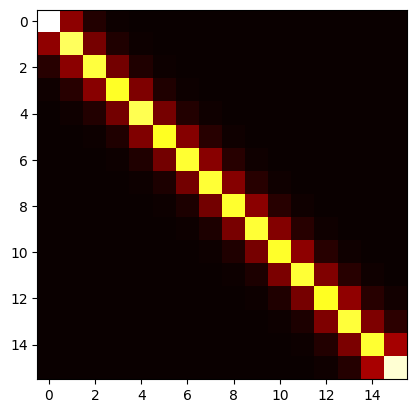

In [ ]:
# Put the model in eval mode
best_model.eval()

# Run the model
out, att_weights = best_model(X_test)

# Compute Test Error
err = (out!=X_test).sum()/X_test.numel()

# Print Test Error
print("Test Error: %f" %(err*100))
print(out[0,:].transpose(0,1))
print(X_test[0,:].int().transpose(0,1))

# Plot Attention
plt.imshow(att_weights[0].detach().numpy(),cmap='hot', interpolation='nearest')
plt.show()

No Hidden State Carryover → Attention Has to Work Harder

RNNs pass hidden states step by step, allowing a gradual flow of information.
Transformers lack this mechanism, meaning attention has to directly learn the full sequence structure.
Result: Attention values become sharper (stronger peaks) and more structured (like in your heatmap).

The model is now faster and better exploits the parallelization offered by modern GPUs (even though here you don't see it because we are working on the CPU).

Nevertheless, this model does not work that well in real problems. Fortunately, researchers from Google introduced the Transformer, which is another RNN-free architecture that improves the simple one discussed in this section.

## **4. Transformers**##

Transformers are neural networks for sequence-to-sequence tasks.
They are very interesting because:

1. They do not involve RNNs and can thus benefit more from the parallelization offered by modern GPUs. The input sequence is processed as a whole, rather than element by element.

2. They can learn long-term dependencies even without a recurrent layer. They mainly rely on self-attention and cross-attention mechanisms that introduce dynamic connections into the architecture where the information (and the gradient) can flow easily.

In the previous section, we saw a basic RNN-free architecture based on MLP, positional encoding, and Bahdanau's attention. You can see Transformers as a substantial improvement of this simple model. In particular, Transformers take benefit of:

1. Better positional encoding based on sinusoids.
2. Both self- and cross-attention mechanisms. The self-attention mechanisms integrate short and long-term contextual information into the encoder and the decoder. The cross-attention relates encoding and decoding states.
3. A better attention mechanism based on query, values, and keys. Moreover, we run multiple attention mechanisms in parallel (multi-head attention) that can focus on different relevant aspects of the input and output sequences.



Here is the famous picture describing the Transformer architecture:

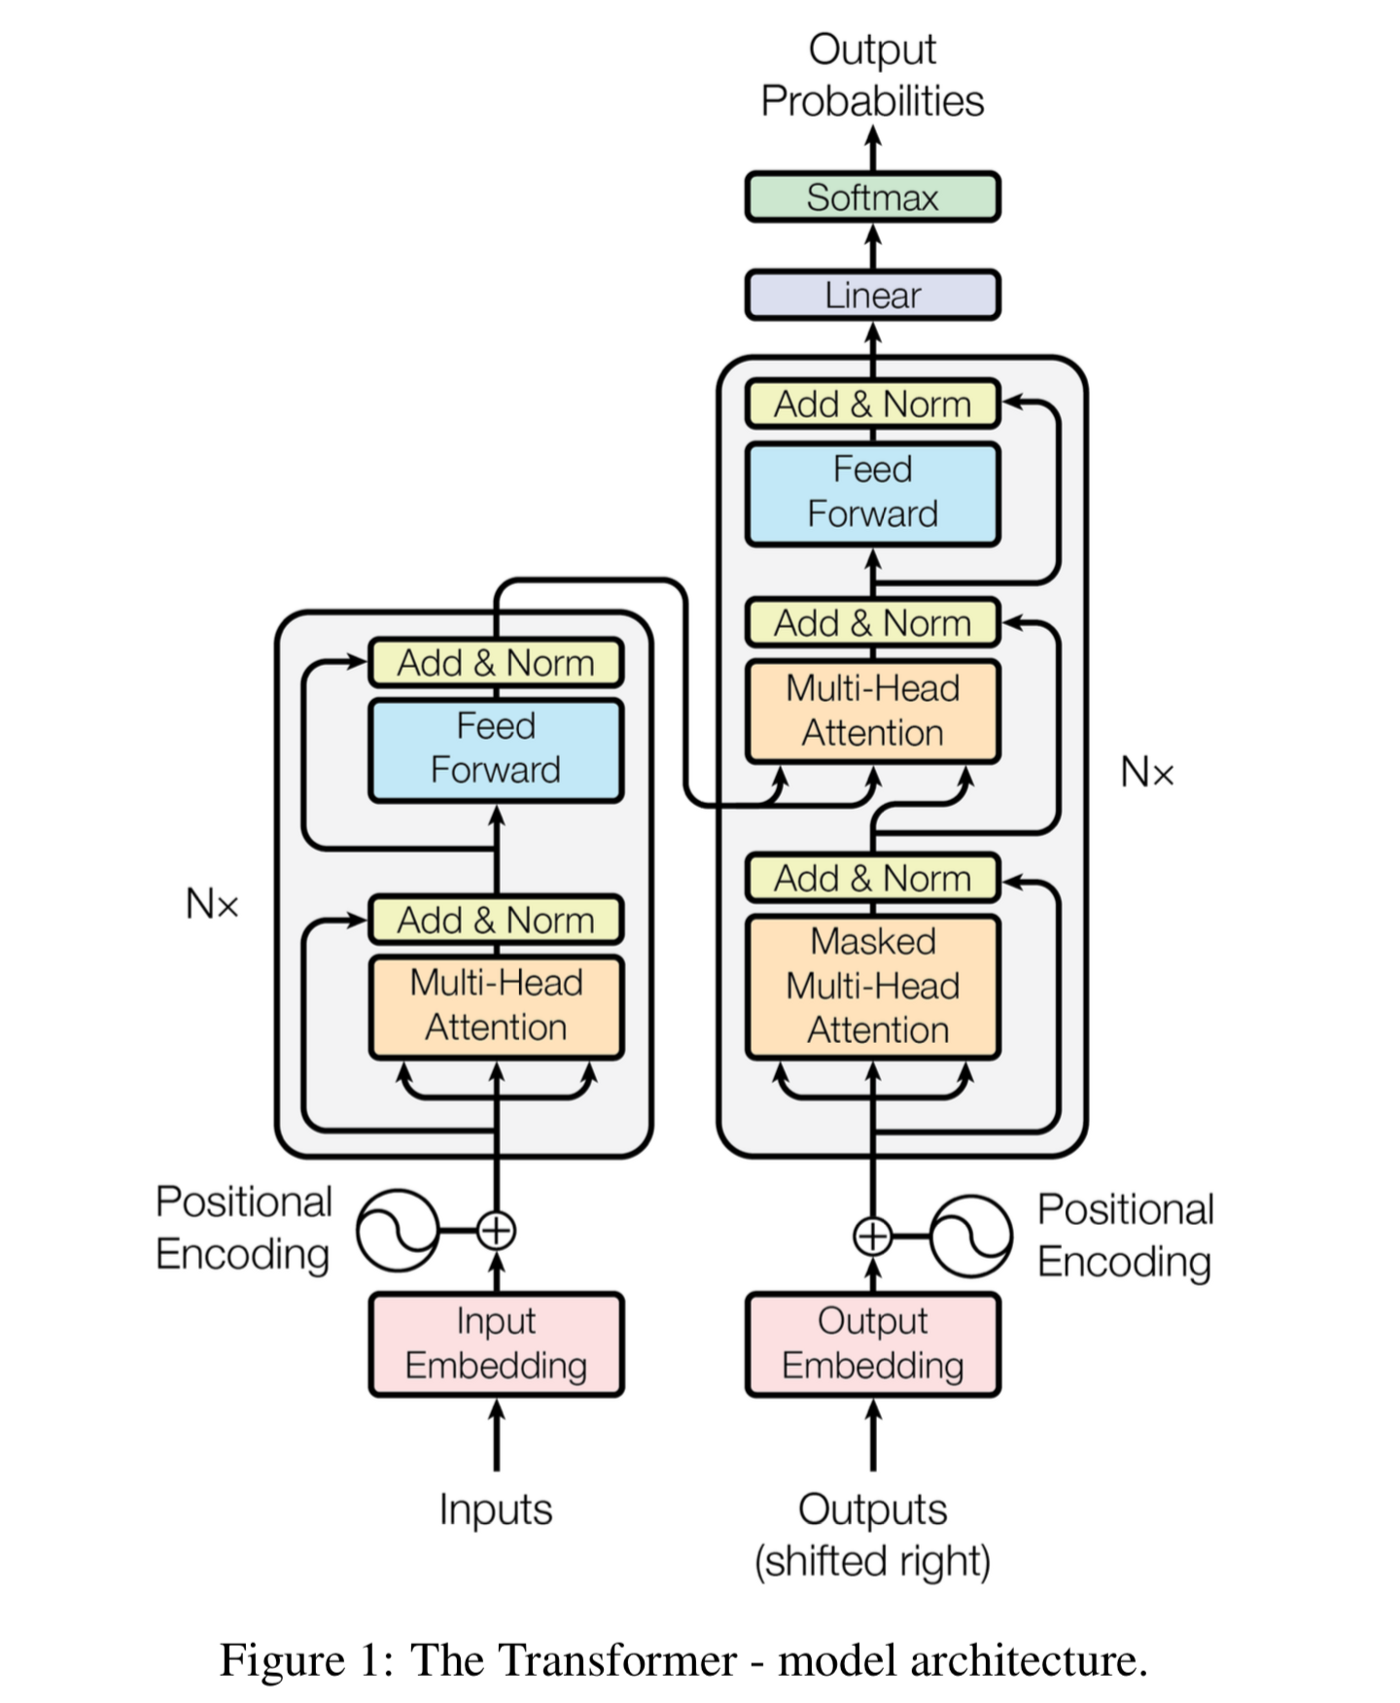

In the following, we will go through this architecture step-by-step.

### **4.1 Positional Embeddings**

In the previous example based on MLPs,  we have seen that we need to inject some positional embeddings to make the model aware of the position of each input. The model becomes permutation-equivariant when we use feedforward neural networks like MLPs for processing a sequence. It thus cannot distinguish whether an input comes before or after another one.

In many tasks (e.g.,  machine translation, speech recognition), however, the position is crucial for interpreting the input.

In the previous section, we just added a simple counter to inject positional information. However, this approach cannot generalize to inputs of variable length. For instance, imagine that you have in input a sequence of length bigger than the maximum one observed during training.

Hence, a better option is to use feature patterns that can potentially generalize to larger sequences.

There are many alternatives here. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies, as follows:

\begin{split}PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}\end{split}

$PE_{(pos,i)}$ represents the positional encoding at position $pos$ in the sequence, and hidden dimensionality $i$. The positional encoding is not a single real number now, but a vector of $d_{model}$ elements (ranging between -1 and 1) that encode the element position using sinusoids of different frequencies.

###**Why sinusoids?**
If we jointly observe the values that the pool of sinusoids takes, we can precisely retrieve the position of the corresponding element.
For instance, let's take this example based on a few sine waves only for simplicity):






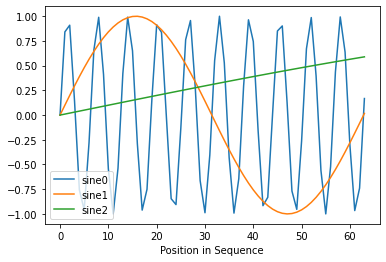

**With both sine & cosine, we get a unique 2D encoding, making each position distinct.**

Think of a clock: If I tell you the hour hand is at 12, you don't know if it's midnight (0:00) or noon (12:00).
→ This ambiguity can confuse the model.

A. Provides a Unique Representation for Each Position

    Since sine and cosine are 90° out of phase, every position has a unique embedding.
    Example:
        Sine(0°) = 0, but Cosine(0°) = 1.
        Sine(90°) = 1, but Cosine(90°) = 0.
    This means no two positions will have identical embeddings.

B. Captures Both Magnitude and Direction

    Sine and cosine together act like X and Y coordinates in a circle (unit circle representation).
    The pair (sin, cos) forms a 2D representation of position, allowing the model to differentiate forward vs backward movement in sequences.

C. Preserves Rotational Invariance (Good for Attention Mechanisms)

   Since Transformers use dot products in attention, having both sine and cosine makes the position embedding more robust to transformations.

Let's assume to observe the following positional embeddings:

$pos_{emb} = [0.6503, 0.9975, 0.1494]^T$

*Could you guess at which element in the sequence they correspond?*

The low-freq sinusoid (sine2) is low (0.1494). This means that we are somewhere close to the beginning of the sequence. Sine1 is close to one, meaning that the only option is element 15th. The guessed position is confirmed if we observe the highest frequency sinusoid sine0.

If we combine all the hints offered by all the sinusoids, we can precisely identify the corresponding element in the input sequence. This scheme generalizes to sequences of different lengths.

###**Why using both sines and cosines?**

The scheme uses sines at even positions and cosines at odd positions.
The authors opted for this positional encoding scheme rather than a single-sinusoid one because they want the model to attend relative positions effortlessly.

Here is a quote from the original paper:

>"*We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions since for any fixed offset k, $PE(pos+k, :)$ can be represented as a linear function of $PE(pos,:)$.*"

It indeed can be [shown](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) that for every sine-cosine pair corresponding to frequency $\omega_k$, there is a linear transformation $M\in \mathbb{R}^{2\times 2}$ (independent of the current position t) where the following equation holds:

\begin{equation}
M.\begin{bmatrix}
      \sin(\omega_k . t) \\
      \cos(\omega_k . t)
  \end{bmatrix} = \begin{bmatrix}
      \sin(\omega_k . (t + \phi)) \\
      \cos(\omega_k . (t + \phi))
  \end{bmatrix}
\end{equation}

Where $\phi$ is the "jump" that we would like to do from the current position t.
This feature implies that we can learn how to attend a different relative position (e.g., my current position t + 3) just by learning a linear transformation.
This property might make learning long and short-term dependencies easier.

###**Why summing up input and positional embeddings?**
Another remark is that we sum the positional embeddings to the input embeddings. We derive the input embeddings by assigning a fixed random vector of dimension $d_{model}$ for each element in the input dictionary.
For instance, if your input dictionary is binary (as done in this tutorial), you need to sample a fixed random vector of dimension $d_{model}$ for the element "0" and another one for the element "1".  We store them in a look-up table and replace all discrete inputs with their corresponding continuous vectors. This operation is done with [torch.nn.embeddings](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

Once we have the input embeddings, we sum them up with the positional embeddings (that are of the same size $d_{model}$). The new vector contains both information on the input and the position of this input within the sequence.

Note that one alternative could have been concatenating the two embeddings rather than summing them up. The Summation, however, works well in practice, and it is the standard approach so far.


Let's now implement them!

In [ ]:
import math
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        # print(pe.shape) # [32,14]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # print(position.shape) #[32,1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        # print(div_term.shape)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # print(pe.shape) #[1,32,14]

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

Let's plot them!

torch.Size([64, 16, 14])
torch.Size([1, 32, 14])


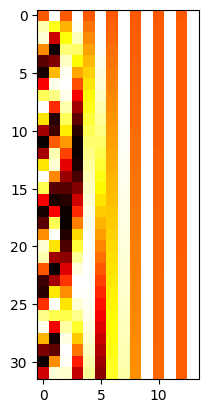

In [ ]:
posemb = PositionalEncoding(14, max_len=32)
x = torch.rand(64, 16, 14)
out = posemb(x)
print(x.shape)
print(posemb.pe.shape)

import matplotlib.pyplot as plt
plt.imshow(posemb.pe.squeeze().detach().numpy(),cmap='hot', interpolation='nearest')
plt.show()

X-Axis: Embedding Dimension (d_model)
Y-Axis: Position in the Sequence (max_len)

You can see that the frequency of the sinusoids decreases when the index increases.

### **4.2 Scaled Dot Product Attention**

Attention is the key component of Transformers.
It is not by chance that the Transformer paper is entitled ["Attention is all you need"](https://arxiv.org/abs/1706.03762).


The attention mechanism used here differs from the Bahdanau attention used so far. The former, called dot product attention, takes as input a set of queries $\mathbb{R}^{L\times d_k}$, keys $\mathbb{R}^{L\times d_k}$, and values $\mathbb{R}^{L\times d_v}$, where $L$ is the sequence length and $d_k$, $d_v$ are the hidden dimensionality for queries/keys and values respectively.

The attention score between the element $i$ and $j$ relies on the similarity of the query and key vectors. The similarity is computed using the dot product.

In math, we calculate the dot product attention as follows:

$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$


The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $L \times L$. Each row represents the attention logits for a specific element to all other elements in the sequence. On these, we apply a softmax and multiply the attention scores with the value vector $V$ to obtain a weighted mean.

In graphical form:

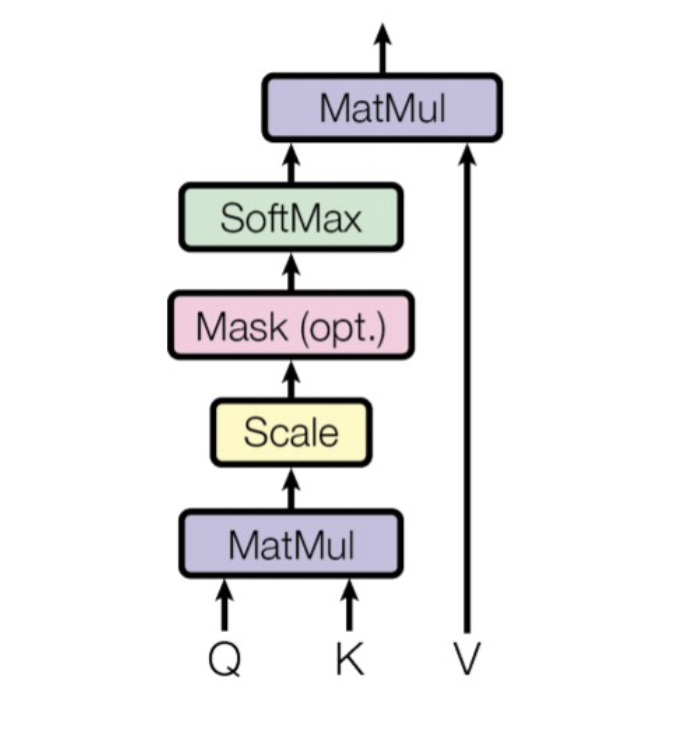

###**Why do we need to scale the dot product?**

As you can see from the equation, the dot product is scaled by $\sqrt{d_k}$.

This scaling factor is crucial to maintain an appropriate variance of attention values after initialization. Remember that we initialize our layers intending to have equal variance throughout the model, and hence,  $Q$ and  $K$ should have a variance close to 1.

If we assume $q_i$ and $k_j$ to be drawn from two independent Gaussian distributions (with zero mean), the variance of the dot product is the following:

$\mathbf{q}^i \sim \mathcal{N}(0,\sigma^2), \mathbf{k}^j \sim \mathcal{N}(0,\sigma^2) \to \text{Var}\left(\sum_{l=1}^{d_k} q^i_l\cdot k^j_l\right) = \sigma^4\cdot d_k$

If we do not scale down the variance, the softmax over the logits will already saturate to 1 for one random element and 0 for all others.  This is undesired because we only select one element rather than multiple ones. Moreover, the gradients through the softmax will be close to zero, so we cannot learn the parameters appropriately.

When we normalize the dot product by dividing it by $\frac{1}{\sqrt{d_k}}$, the variance will be $\sigma^4$ and will not depend anymore on $d_k$. Now, if we make sure that the variance of the keys and queries stays close to one, the variance of the dot product is the same as the variance of the original key and query vectors. We can help make sure the variance is close to one using proper weight initialization and layer normalization.




###**The role of masks**
If some cases, we want to prevent the model from attending to some elements. In the context of Transformers, we do this for two reasons:

1. When we process input (and output) sequences of different sizes, we perform zero padding to create batches. If one sequence in the batch is short, we fill it with zeros to match the length of the longest sequence in the batch. We don't want our model to focus on these "fake" steps.

2. As we will see, the decoder is autoregressive, and we do not want its internal self-attention mechanism to attend to future elements not already predicted.

Masking is done with a simple mask that sets the attention logits to a very low value.

Finally, we can write the code for the scaled dot product attention:

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)

    if mask is not None:
      attn_logits  = attn_logits.masked_fill(mask == 0, -float("Inf"))

    attention = torch.nn.functional.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)

    return values, attention

Let;s run it and do some prints to make sure the dimensionalities are fine:

In [ ]:
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)

# Without Mask
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

# With Mask
mask = torch.triu(torch.ones(3, 3), diagonal=0).transpose(0,1)
values, attention = scaled_dot_product(q, k, v, mask=mask)

# Without Mask
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)
print("Mask\n", mask)

Q
 tensor([[0.4239, 0.8345],
        [1.4545, 0.7717],
        [0.4815, 0.1317]])
K
 tensor([[ 1.0541, -1.3938],
        [ 0.3637, -0.6814],
        [ 0.6829, -0.1563]])
V
 tensor([[ 0.3218, -0.5370],
        [-0.1589,  0.2590],
        [ 0.2952, -0.5257]])
Values
 tensor([[ 0.1644, -0.2913],
        [ 0.1965, -0.3438],
        [ 0.1692, -0.2958]])
Attention
 tensor([[0.2442, 0.3023, 0.4535],
        [0.3261, 0.2365, 0.4374],
        [0.3529, 0.2981, 0.3490]])
Q
 tensor([[0.4239, 0.8345],
        [1.4545, 0.7717],
        [0.4815, 0.1317]])
K
 tensor([[ 1.0541, -1.3938],
        [ 0.3637, -0.6814],
        [ 0.6829, -0.1563]])
V
 tensor([[ 0.3218, -0.5370],
        [-0.1589,  0.2590],
        [ 0.2952, -0.5257]])
Values
 tensor([[ 0.3218, -0.5370],
        [ 0.1197, -0.2024],
        [ 0.1692, -0.2958]])
Attention
 tensor([[1.0000, 0.0000, 0.0000],
        [0.5797, 0.4203, 0.0000],
        [0.3529, 0.2981, 0.3490]])
Mask
 tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]

## **4.3 Multi-Head Attention**

The scaled dot product attention allows a network to attend over a sequence.

However, often there are multiple different aspects of the sequence that we want to simultaneously attend.  

*What about using multiple attention mechanisms running in parallel?*

In Transformers, we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features.

The operations needed to implement multi-head attention are highlighted in the following figure:

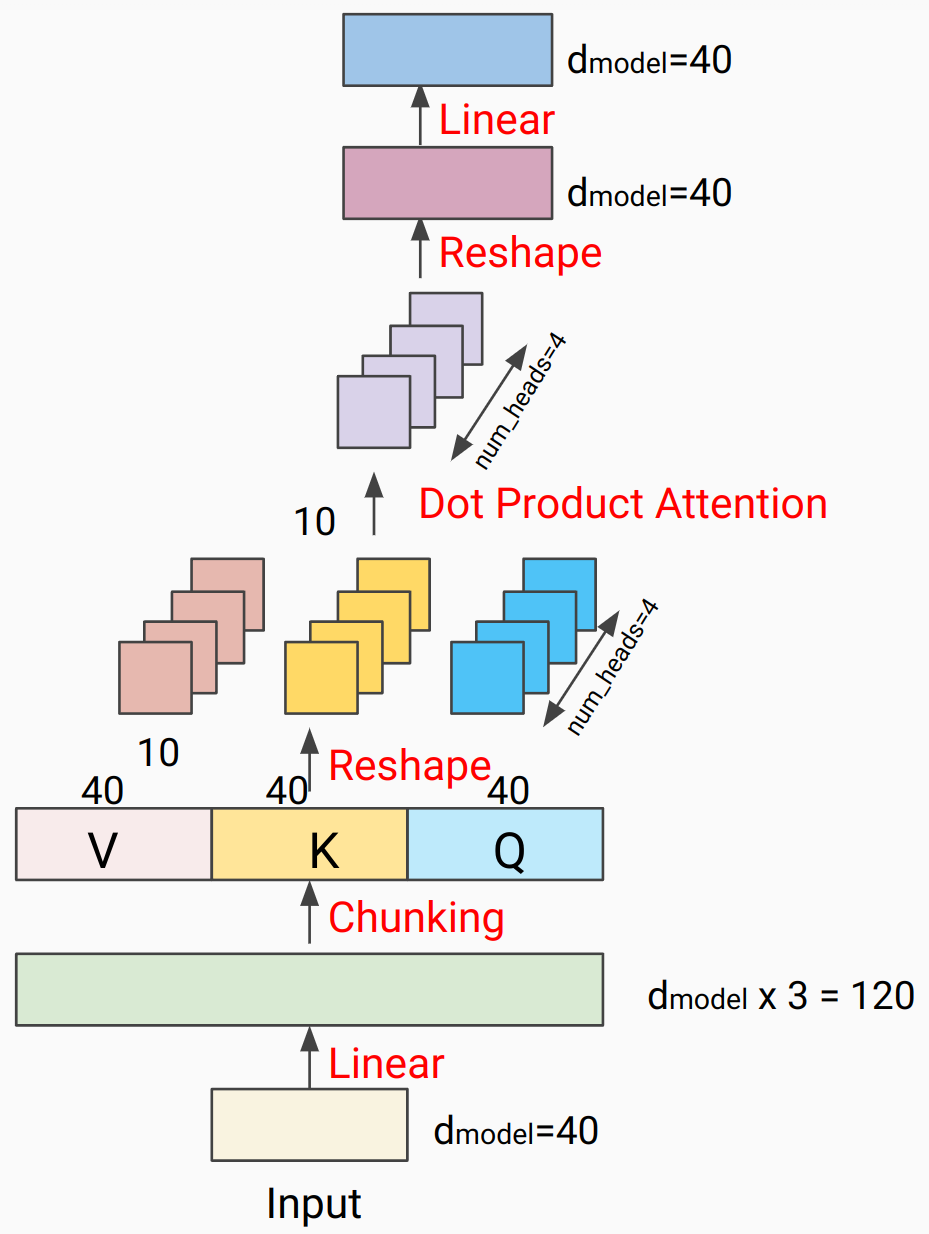

Here is the code for multi-head attention:

In [ ]:
class MultiheadAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = torch.nn.Linear(embed_dim, 3 * embed_dim)
        self.o_proj = torch.nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3)  # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)
        return o, attention

Let's run it and print some shapes:

In [ ]:
MHA = MultiheadAttention(40,4)
x = torch.rand(64, 16, 40)
out, att = MHA(x)
print(out.shape)
print(att.shape)

torch.Size([64, 16, 40])
torch.Size([64, 4, 16, 16])


## **4.4 Transformer Encoder**

All the basic ingredients are there. We just need to put everything together and build the encoder shown in the transformer figure above.


The encoder consists of $N$ identical blocks that are applied one after the other. Each block performs the following computations:
1. the input is first passed through a Multi-Head Attention block.
2. The output is added to the original input using a residual connection,
3. We apply Layer Normalization.
4. We process the normalized representations with a small MLP (which also used residual connections and layer normalization).


#### **Why do we need residual connections?**

The residual connections are crucial in the Transformer architecture for two reasons:

1. Similar to ResNets, Transformers are designed to be very deep. Some models contain more than 24 blocks in the encoder. Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.

2. Without the residual connection, the information about the original sequence might be lost. Remember that the Multi-Head Attention layer ignores the position of elements in a sequence, and can only learn it based on the input positional embeddings. The positional embeddings are applied to the original input of the model only.  Removing the residual connections would mean that the positional information might be lost after the first attention layer. The residual information allows us to inject again this information, thus helping the model.


#### **Why do we need layer normalization?**
Layer Normalization plays an important role as well. It enables faster training and provides regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence. We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and LayerNorm has shown to perform particularly well in practice.


#### **Why do we need an MLP after the attention?**
The MLP adds capacity to the model and allows transformations on each sequence element separately. You can imagine this as a way for the model to “post-process” the new information added by the previous Multi-Head Attention, and prepare it for the next attention block.


The code for the encoder block is the following:

In [ ]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.0):
        """
        Args:
            input_dim: Dimensionality of the input
            num_heads: Number of heads to use in the attention block
            dim_feedforward: Dimensionality of the hidden layer in the MLP
            dropout: Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(d_model, num_heads)

        # Two-layer MLP
        self.linear_net = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(d_model, d_model),
        )

        # Layers to apply in between the main layers
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        # Attention part
        attn_out, _ = self.self_attn(x)
        x = x + self.dropout(attn_out) # resedual connection
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)
        return x

Let's run the code and print the shapes:

In [ ]:
enc_block = EncoderBlock(40, 4, 0.1)
x = torch.rand(64, 16, 40)
out = enc_block(x)
print(out.shape)

torch.Size([64, 16, 40])


Now, we can create the full Transformer Encoder by adding the positional embeddings and stacking multiple encoder blocks:

In [ ]:
class TransformerEncoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, vocab_size, num_heads=4, dropout=0.1):
        super().__init__()

        self.posemb = PositionalEncoding(d_model, max_len=100)
        self.embed = torch.nn.Embedding(vocab_size, d_model)
        self.layers = torch.nn.ModuleList([EncoderBlock(d_model,num_heads,dropout) for _ in range(num_layers)])

    def forward(self, x):
        x = self.embed(x.squeeze(-1))
        x = x + self.posemb(x)

        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
encoder = TransformerEncoder(
            num_layers=2,
            d_model=40,
            vocab_size=2,
            num_heads=4,
            dropout=0.1,
        )
out = encoder(X_train[0:64].int())
print(out.shape)

NameError: name 'TransformerEncoder' is not defined

## **4.4 Transformer Decoder**
As you can see from the Transformer figure above, the architecture is similar to the encoder. One additional ingredient is the cross-attention layer. Cross-attention allows us to relate encoding and decoding states.

Cross-attention still relies on scaled dot product attention. Using attention, the decoder can perform a weighted sum of the encoded states. The only difference with self-attention is that now the queries come from the decoder and the keys (and values) from the encoder.

Here is the code:

In [ ]:
class CrossMultiheadAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.q_proj = torch.nn.Linear(embed_dim, embed_dim)
        self.k_proj = torch.nn.Linear(embed_dim, embed_dim)
        self.v_proj = torch.nn.Linear(embed_dim, embed_dim)

        self.o_proj = torch.nn.Linear(embed_dim, embed_dim)

    def forward(self, x, encoder_out, mask=None):
        batch_size, seq_length, embed_dim = x.size()


        # Getting Queries, Keys, and Values
        q = self.q_proj(x)
        k = self.k_proj(encoder_out)
        v = self.k_proj(encoder_out)

        # Separating heads

        q = q.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        q = q.permute(0,2,1,3) # [Batch, Head, SeqLen, Dims]

        k = k.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        k = k.permute(0,2,1,3) # [Batch, Head, SeqLen, Dims]

        v = v.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        v = v.permute(0,2,1,3)# [Batch, Head, SeqLen, Dims]


        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask)

        values = values.permute(0, 2, 1, 3)  # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)
        return o, attention

In [ ]:
CMHA = CrossMultiheadAttention(40,4)
x = torch.rand(64, 16, 40)
encoder_out = torch.rand(64, 16, 40)
out, att = CMHA(x, encoder_out)

print(out.shape)
print(att.shape)

torch.Size([64, 16, 40])
torch.Size([64, 4, 16, 16])


Similarly to what is done for the encoder, we can build the decoder block. The main difference is that we now have cross-attention right after the self-attention one. As you can see, we still use residual connections, normalization, and the final MLP.

### **Why do we need self-attention in the decoder?**
Self-attention can be useful in the decoding stage as well. This way, the model can perform the current prediction by analyzing the previous predictions (but not the future ones as we apply a mask).

The code is the following:

In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.0):
        """
        Args:
            input_dim: Dimensionality of the input
            num_heads: Number of heads to use in the attention block
            dim_feedforward: Dimensionality of the hidden layer in the MLP
            dropout: Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(d_model, num_heads)
        self.cross_attn = CrossMultiheadAttention(d_model, num_heads)

        # Two-layer MLP
        self.linear_net = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(d_model, d_model),
        )

        # Layers to apply in between the main layers
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, encoder_out, mask=None):

        # Self-Attention part
        attn_out, _ = self.self_attn(x, mask)

        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # Cross-Attention part
        attn_out, self.att_w = self.cross_attn(x, encoder_out, mask)
        x = x + self.dropout(attn_out)
        x = self.norm2(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm3(x)
        return x

In [ ]:
dec_block = DecoderBlock(40, 4)
x = torch.rand(64, 16, 40)
encoder_out = torch.rand(64, 16, 40)
out = dec_block(x, encoder_out)
print(out.shape)

torch.Size([64, 16, 40])


We now stack multiple layers and add the positional embeddings as well:


In [ ]:
class TransformerDecoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, vocab_size, num_heads=4, dropout=0.1):
        super().__init__()

        self.posemb = PositionalEncoding(d_model, max_len=100)
        self.embed = torch.nn.Embedding(vocab_size, d_model)
        self.layers = torch.nn.ModuleList([DecoderBlock(d_model,num_heads,dropout) for _ in range(num_layers)])

    def forward(self, x, encoder_out, mask=None):
        x = self.embed(x.squeeze(-1))
        x = x + self.posemb(x)

        for layer in self.layers:
            x = layer(x, encoder_out, mask)
        return x

In [ ]:
decoder = TransformerDecoder(
            num_layers=2,
            vocab_size=2,
            d_model=40,
            num_heads=4,
            dropout=0.1,
        )
encoder_out = torch.rand(64, 16, 40)

out = decoder(X_train[0:64].int(), encoder_out)

print(out.shape)

torch.Size([64, 16, 40])


### **Why do we need positional embeddings for the decoder?**
The positional embeddings are useful at the decoding stage as well to inform the model about the current decoding step.

We can now put together a single model by combining the encoder and the decoder:

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, num_layers, num_heads, dropout, out_dim):
        super().__init__()
        self.encoder = TransformerEncoder(num_layers, d_model, src_vocab, num_heads, dropout)
        self.decoder = TransformerDecoder(num_layers, d_model, trg_vocab, num_heads, dropout)
        self.linear_out = torch.nn.Linear(in_features=d_model, out_features=out_dim)

    def forward(self, x, y, mask=None):
        e_outputs = self.encoder(x)

        # The targets y must be shifted by 1 to the right
        # This is because we need the previous output
        # (and not the current one which is what we want to predict)
        y_shift = torch.roll(y, 1, 1)

        d_output = self.decoder(y_shift, e_outputs,mask)
        out = self.linear_out(d_output)
        if not(self.training):
          # Apply the sigmoid and a threshold on it.
          out = (torch.sigmoid(out) > 0.5).int()

        return out

In [ ]:
transformer = Transformer(src_vocab=2,
            trg_vocab=2,
            num_layers=2,
            d_model=40,
            num_heads=4,
            dropout=0.1,
            out_dim=1
        )

out = transformer(X_train[0:64].int(), X_train[0:64].int())

print(out.shape)

torch.Size([64, 16, 1])


As you can see, the model is autoregressive. This term means that the prediction done at step $t-1$ prediction is fed back into the input. The knowledge of the previous predictions can make better predictions in current and future decoding steps.

At inference time, everything has to be sequential: we take the current prediction and feed it into the next decoding step. Fortunately, at training time, we can process everything in parallel thanks to teacher forcing.


###**What is "teacher forcing"?**
At training time, we have a big advantage because we already know the labels for all output elements.
Instead of using the model predictions, we can use the labels themselves at training time!

This approach is called teacher forcing. We just have to shift the labels to the right by one (to ensure the current input corresponds to the previous label) and feed them into the model. This way everything can be processed in parallel.

When we use teacher forcing, we need to mask the decoding attention mechanisms (both self- and cross-attention). Otherwise, the model can easily "cheat" by attending to the next label fed into the decoder directly (which is what we want to predict). If this is the case there is a "label leak" and the model cannot learn anything useful as it just copies and pastes labels. When implementing Transformers, it is important to ensure this does not happen, as it is easy to introduce a bug in the masking process.

Finally, we can train our model for the sequence-replay task:

In [ ]:
# Hyperparameters
num_epoch = 200
batch_size = 50
lr = 0.004

# Initialization
transformer =  Transformer(src_vocab=2, trg_vocab=2, num_layers=1, d_model=24, num_heads=4, dropout=0.0, out_dim=1)
transformer  = transformer.to('cpu')

loss = torch.nn.BCEWithLogitsLoss()
loss = loss.to('cpu')
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)

def training_loop(X, y, model, loss, optimizer, num_epoch=500, batch_size=100):

  # Getting number of input samples
  N = X.shape[0]

  # Training Loop
  for epoch in range(num_epoch):
    for i in range(0, N, batch_size):

      # Minibatch selection (on X and y)
      # Your code here. Aim for 2 lines
      Xi = X[i:i+batch_size, :, :]
      yi = y[i:i+batch_size, :, :]

      # Decoding Mask
      mask = torch.triu(torch.ones(yi.shape[1], yi.shape[1], device=yi.device), diagonal=0)
      mask = mask.transpose(0,1)

      # Run the RNN encoder/decoder
      # Your code here. Aim for 1 line
      logits  = model(Xi.int(), yi.int(), mask=mask)

      # Compute the loss
      # Your code here. Aim for 1 line
      l = loss(logits, yi)

      # Update the parameters
      # Your code here. Aim for 3 line
      transformer.zero_grad()
      l.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
      optimizer.step()

    # Print loss
    if (epoch + 1) % 10 == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))

# Run the training loop
training_loop(X_train.to('cpu'), X_train.to('cpu'), transformer, loss, optimizer, num_epoch, batch_size)

Epoch 010: Train_loss: 0.5874 
Epoch 020: Train_loss: 0.0004 
Epoch 030: Train_loss: 0.0001 
Epoch 040: Train_loss: 0.0000 
Epoch 050: Train_loss: 0.0000 
Epoch 060: Train_loss: 0.0000 
Epoch 070: Train_loss: 0.0000 
Epoch 080: Train_loss: 0.0000 
Epoch 090: Train_loss: 0.0000 
Epoch 100: Train_loss: 0.0000 
Epoch 110: Train_loss: 0.0000 
Epoch 120: Train_loss: 0.0000 
Epoch 130: Train_loss: 0.0000 
Epoch 140: Train_loss: 0.0000 
Epoch 150: Train_loss: 0.0000 
Epoch 160: Train_loss: 0.0000 
Epoch 170: Train_loss: 0.0000 
Epoch 180: Train_loss: 0.0000 
Epoch 190: Train_loss: 0.0000 
Epoch 200: Train_loss: 0.0000 


The model converges quite quickly. Let's take a look at the heads learned in the cross-attention block:


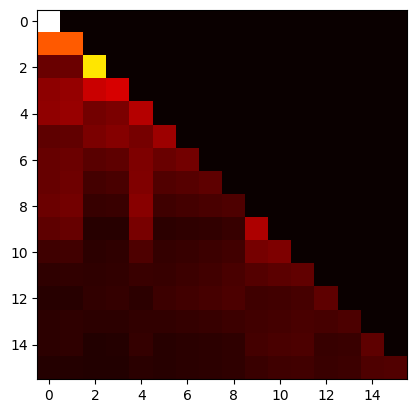

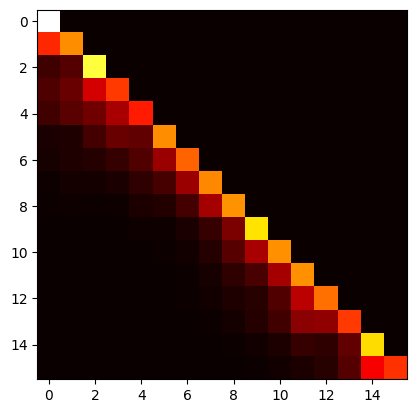

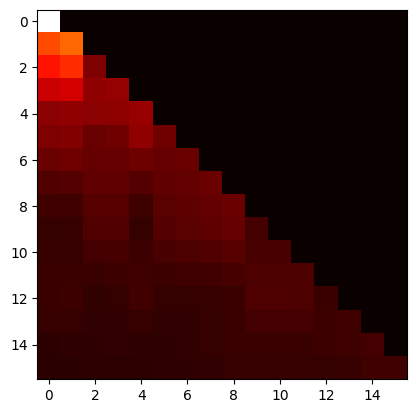

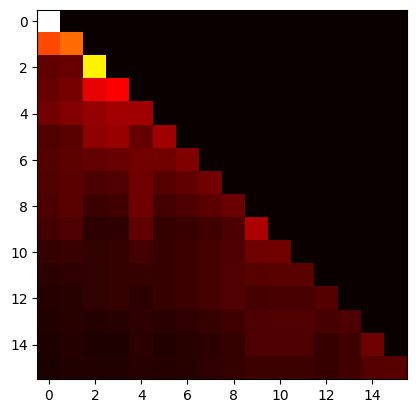

In [ ]:
att_heads = transformer.decoder.layers[-1].att_w

import numpy as np
import matplotlib.pyplot as plt
plt.imshow(att_heads[0,0].detach().numpy(),cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(att_heads[0,1].detach().numpy(),cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(att_heads[0,2].detach().numpy(),cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(att_heads[0,3].detach().numpy(),cmap='hot', interpolation='nearest')
plt.show()

You can see that the model attends to previous elements to perform the current prediction. This pattern is a possible solution as, due to self-attention, each encoded state depends on the other ones. As an exercise, try to remove self-attention, and you should notice that at least one head has a strong diagonal pattern.

## **4.5 Advantages and Disadvantages**
Transformers are the dominant neural network these days. Their architecture is clever and well-designed.

Here are their main advantages:
- They process the sequence in parallel and not sequentially as RNNs. This feature makes them more suitable for current GPUs and faster than RNNs (but more memory-demanding).

- They outperform RNNs for many sequence-to-sequence processing tasks such as machine translation and speech processing.

- They are a very flexible model. For instance, they are used in standard classification and regression tasks (i.e., non-sequence-to-sequence) like computer vision. In this case, we can use the transformer encoder only and add a simple classifier. Transformers can be used as an alternative to convolutional neural networks as well, as they easily learn local dependencies too.

Here are their main disadvantages:
- The transformers are memory-demanding. They process the whole sequence in parallel, but this costs memory. This issue is especially true for long sequences. Due to the nature of the attention mechanisms, the amount of memory required grows quadratically with the sequence length. This problem is called the "quadratic memory bottleneck". To mitigate it,  extensions of Transformers have been proposed, such as [LongFormers](https://arxiv.org/abs/2004.05150), [LinFormers](https://arxiv.org/abs/2006.04768), [ReFormers](https://arxiv.org/abs/2001.04451), [Dual-Path Transformers](https://arxiv.org/abs/2010.13154). A simple way to mitigate this issue is to add a stride convolutional front-end before the transformer that downsamples the input sequence.
- Even though transformers usually perform better than RNNs, it is hard to make them work well. You need to carefully tweak all the hyperparameters. Otherwise, the model does not perform well or, very often, it even does not converge.
- Even though the transformers are theoretically faster than RNN, they often require more parameters to achieve good performance. This trend makes memory issues even worse and diminishes the speed advantages. Moreover, typically transformers require a larger number of iterations to converge.

